
Made by Roman Kiryanov, roman.kiryanov@skoltech.ru


## Initialization

### Preinstall required libraries

In [0]:
#!pip install dlib
#!pip install opencv-python
#!pip install --upgrade imutils

import dlib
import cv2

import numpy as np
import pandas as pd

import imutils
import os

from PIL import Image

from matplotlib import pyplot as plt

### Drive mounting for Data

In [2]:
# mounting drive folder

from google.colab import drive
drive.mount('/content/gdrive') #, force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
path = 'gdrive/My Drive/Colab Notebooks/DL_Project/'
cwd = os.getcwd()
os.chdir(path)

## Get table data

In [8]:
datadir = 'Twins'

metadata = pd.read_csv(f'{datadir}/twins-relationship-info.csv', index_col = 0)
metadata['subject_id1'] = metadata['subject_id1'].apply(lambda x: int(x.split('S')[1]))
metadata['subject_id2'] = metadata['subject_id2'].apply(lambda x: int(x.split('S')[1]))

# filter 
metadata_identical = metadata[(metadata['relationship_type']=='Identical')]
metadata_fraternal = metadata[(metadata['relationship_type']=='Fraternal')]
metadata_sibling   = metadata[(metadata['relationship_type']=='Sibling')]

#metadata_different = metadata[(metadata['relationship_type']=='Fraternal') | (metadata['relationship_type']=='Sibling')]

print(len(metadata_identical), len(metadata_fraternal), len(metadata_sibling))
#metadata_different.head()


352 32 8


### Convert table data to dict
Я использую Counter так как обычный дикт при запросе несуществующего элемента выкинет ошибку, а этот - 0

In [0]:
from collections import Counter

In [0]:
identical = Counter()
for i, subj_id1 in enumerate( metadata_identical[['subject_id1', 'subject_id2']].values):  
    identical[subj_id1[0]] = subj_id1[1]
    
fraternal = Counter()
for i, subj_id1 in enumerate( metadata_fraternal[['subject_id1', 'subject_id2']].values):  
    fraternal[subj_id1[0]] = subj_id1[1]

sibling = Counter()
for i, subj_id1 in enumerate( metadata_sibling[['subject_id1', 'subject_id2']].values):  
    sibling[subj_id1[0]] = subj_id1[1]

In [0]:
different = Counter()
for i, subj_id1 in enumerate( metadata[['subject_id1', 'subject_id2']].values):  
    different[subj_id1[0]] = subj_id1[1]

### One more table with views
Сортировка информации о том какие файлы какие имеют виды. Берем только фронтальные

In [0]:
datadir = 'Twins'

metadata2 = pd.read_csv(f'{datadir}/image-metadata-2.0.csv')
# filter 
metadata2 = metadata2[(metadata2[' yaw']==0)&(metadata2[' expression']!=' Happiness')&(metadata2[' glasses']==' none')]
metadata2['person_id'] = metadata2['filename'].apply(lambda x: int(x.split('d')[0]))
metadata2['view_id'] = metadata2['filename'].apply(lambda x: x.split('d')[1].split('.')[0])

df_ids_views = metadata2.groupby('person_id').view_id.apply(tuple).to_frame()

In [11]:
df_ids_views.head()

,view_id
person_id,
90003,"(17, 18, 40, 42, 60, 61)"
90004,"(17, 18, 40, 42, 60, 61, 83, 95, 98, 110, 114,..."
90005,"(17, 18, 40, 42, 60, 61, 83, 95, 98, 110, 114,..."
90006,"(14, 15, 37, 39, 57, 58)"
90007,"(17, 18, 36, 54, 55)"


In [0]:
views = Counter()
for i, num in enumerate( list(df_ids_views.index) ):
    views[num] = list(df_ids_views.values)[i]

### Data Loader
Простенький даталоадер который берет изображение, определяет по таблице близнеца и загружает все возможные пары видов

In [0]:
def get_img_path(img_id, view):
    return os.path.join('Twins','nd-twins-0006/faces', f'{img_id}/{img_id}d{view}__face.jpg')

In [0]:
def load_same_person_pairs(pairs, views):
    pairs_keys = np.array(list(pairs.keys()))
  
    for id_X in pairs_keys:
        np.random.shuffle(pairs_keys)
        id_a = pairs_keys[0]
        try:
            views_a = views[id_a][0]
        except TypeError:
            views_a = views[id_a]
        for i in range(0, len(views_a)-1):
            for j in range(i+1, len(views_a)):
                path_a = get_img_path(id_a, views_a[i])
                path_b = get_img_path(id_a, views_a[j])
                im_A = Image.open(path_a)
                im_B = Image.open(path_b)
                yield [im_A, im_B]

In [0]:
def load_different_person_pairs(pairs, views):
    pairs_keys = np.array(list(pairs.keys()))
    
    for id_X in pairs_keys:
        np.random.shuffle(pairs_keys)
        id_a = pairs_keys[0]
        id_b = pairs[id_a]
        
        try:
            views_a = views[id_a][0]
        except TypeError:
            views_a = views[id_a]
        try:
            views_b = views[id_b][0]
        except TypeError:
            views_b = views[id_b]
        for i in views_a:
            for j in views_b:
                path_a = get_img_path(id_a, i)
                path_b = get_img_path(id_b, j)
                im_A = Image.open(path_a)
                im_B = Image.open(path_b)
                yield [im_A, im_B]

In [0]:
a = next(iter(load_different_person_pairs(fraternal, views)))
b = next(iter(load_same_person_pairs(fraternal, views)))
c = next(iter(load_different_person_pairs(sibling, views)))
d = next(iter(load_different_person_pairs(identical, views)))

In [0]:
np.random.shuffle( np.array(list(fraternal.keys())))

In [190]:
0[0]

TypeError: ignored

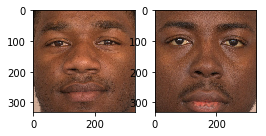

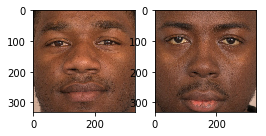

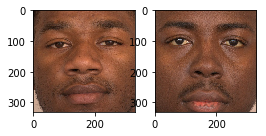

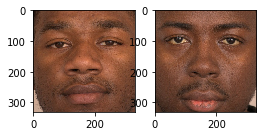

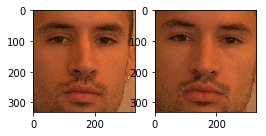

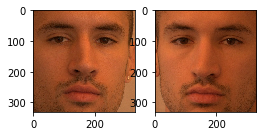

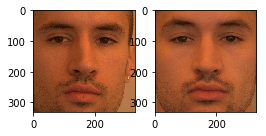

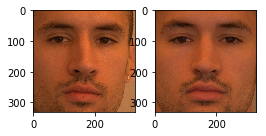

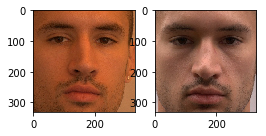

In [95]:
coun = 1
for [A, B] in iter(load_different_person_pairs(fraternal, views)):
    plt.figure(figsize=(4,3))
    plt.subplot(121)
    plt.imshow(A)
    plt.subplot(122)
    plt.imshow(B)
    plt.show()
    coun +=1
    if coun == 10:
        break
    

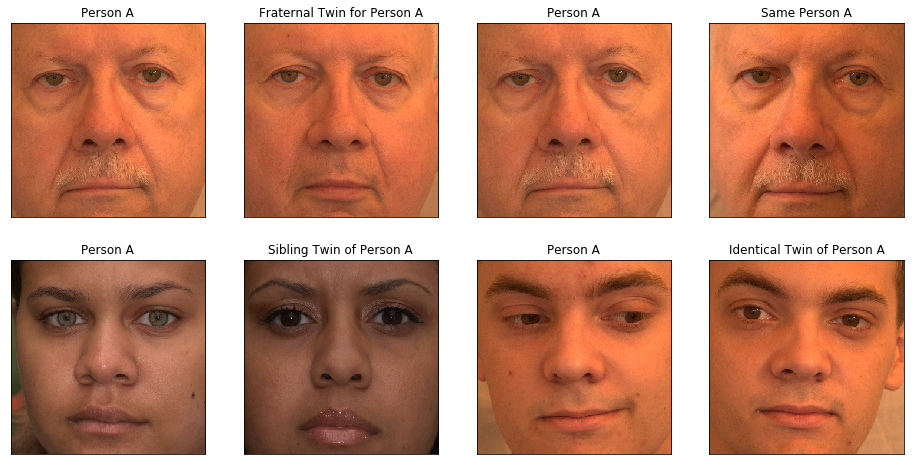

In [64]:
plt.figure(figsize=(16,8))
plt.subplot(241, title='Person A', xticks=(()), yticks=(()))
plt.imshow(a[0])
plt.subplot(242, title='Fraternal Twin for Person A', xticks=(()), yticks=(()))
plt.imshow(a[1])

plt.subplot(243, title='Person A', xticks=(()), yticks=(()))
plt.imshow(b[0])
plt.subplot(244, title='Same Person A', xticks=(()), yticks=(()))
plt.imshow(b[1])

plt.subplot(245, title='Person A', xticks=(()), yticks=(()))
plt.imshow(c[0])
plt.subplot(246, title='Sibling Twin of Person A', xticks=(()), yticks=(()))
plt.imshow(c[1])

plt.subplot(247, title='Person A', xticks=(()), yticks=(()))
plt.imshow(d[0])
plt.subplot(248, title='Identical Twin of Person A', xticks=(()), yticks=(()))
plt.imshow(d[1])
plt.show()

## Preprocess Functions

In [0]:
os.chdir(cwd)
from dlib_fd import dlib_landmark_detector # face detector
#from hr_e import head_rotation_estimator # rotation estimation

In [0]:
os.chdir(path)

In [0]:
# initialize detector:
# cnn_flag = True to use CNN-based model.If False, use HOG-based model
# bb_detector_path = full path except name to bounding box detector (first stage of face detection)
# landmark_predictor_path = full path except name to 68-points trained weights for detector of face landmarks

dfd = dlib_landmark_detector(cnn_flag='True', 
                             bb_detector_path = './mmod_human_face_detector.dat', 
                             landmark_predictor_path = './shape_predictor_68_face_landmarks.dat' )

In [0]:
def distance(shape1, shape2): 
    return np.sqrt( np.power(shape1 - shape2, 2).sum(axis=1)) #MSE

In [0]:
def get_features( pairs, views, cut_off_num, same_preson=False, flipped=False):
    vectors = []
    counter, nd = 1, 0
    
    if same_preson:
        load = load_same_person_pairs
    else:
        load = load_different_person_pairs
    
    for [img_A, img_B] in iter(load(pairs, views)): 
        # Face A prepare
        img_8bit = np.array( img_A )
        img_8bit = np.pad(img_8bit, ((0,50),(40,40),(0,0)), mode='median')
        # Face A detect
        dfd.reset()
        dfd.face_detect(img_8bit, visualize=False)
        
        # Face A crop and center
        face_cropped = dlib.get_face_chip(dfd._rescaled_image.copy(), dfd.landmark_shape, size=256, padding=0.15)
        dfd.reset()
        dfd.face_detect(face_cropped, visualize=False)
        # Face A get landmark points
        A__img_shape = dfd.get_original_size_landmarks()
        
        if flipped:
            face_cropped = np.flip(face_cropped, axis=1)
            dfd.reset()
            dfd.face_detect(face_cropped, visualize=False)
            B__img_shape = dfd.get_original_size_landmarks()
            #print(B__img_shape[:3])
            #plt.imshow(img_A )
            #plt.show()
        else:
            # Face B - the same
            img_8bit = np.array( img_B )
            img_8bit = np.pad(img_8bit, ((0,50),(40,40),(0,0)), mode='median')
            dfd.reset()
            dfd.face_detect(img_8bit, visualize=False)
            face_cropped = dlib.get_face_chip(dfd._rescaled_image.copy(), dfd.landmark_shape, size=256, padding=0.15)
            dfd.reset()
            dfd.face_detect(face_cropped, visualize=False)
            B__img_shape = dfd.get_original_size_landmarks()
        
        
        if (A__img_shape is None) or (B__img_shape is None):
            nd +=1
        else:
            vectors.append(distance(A__img_shape, B__img_shape))
            counter+=1
        
        if counter == cut_off_num:
            break
    print('Detected:', counter, 'N/Detected:', nd)
    return vectors

In [0]:
def plot_vectors(vectors_array, names_array, print_areas=True):
  
    plt.figure(figsize=(16,8))
    plt.title('Median of vectors', fontsize=16)
    plt.xlabel('Points', fontsize=12)
    plt.ylabel('$\Delta$, pix', fontsize=12)
    
    std_max = 0
    for vectors, name in zip(vectors_array, names_array):
        median = np.median(vectors, axis=0)
        std = np.std(vectors, axis=0)
        if (median+std).max() > std_max:
            std_max = (median+std).max()
        
        x = np.linspace(0,len(median),len(median))
        plt.plot(median, label=name)
        plt.fill_between( x, median+std, median-std, alpha=0.2)
    
    if print_areas:
        plt.plot(np.ones(10)*17,np.linspace(-5,std_max+2,10),'black',alpha=0.5)
        plt.plot(np.ones(10)*28,np.linspace(-5,std_max+2,10),'black',alpha=0.5)
        plt.plot(np.ones(10)*48,np.linspace(-5,std_max+2,10),'black',alpha=0.5)
        plt.plot(np.ones(10)*37,np.linspace(-5,std_max+2,10),'black',alpha=0.5)
    
        plt.text(5,std_max+1,'Jaw', fontsize=16)
        plt.text(19,std_max+1,'EyeBrows', fontsize=16)
        plt.text(31,std_max+1,'Nose', fontsize=16)
        plt.text(40,std_max+1,'Eyes', fontsize=16)
        plt.text(52,std_max+1,'Mouth', fontsize=16)
        
    plt.ylim([-5,std_max+3])
    plt.xlim([0, len(median)])
    plt.legend()
    plt.show()

In [0]:
def cut_slice(vectors, part):
    if part == 'Jaw':
        return np.array(vectors)[:,:17]
    elif part == 'EyeBrows':
        return np.array(vectors)[:,17:27]
    elif part == 'Nose':
        return np.array(vectors)[:,27:36]
    elif part == 'Eyes':
        return np.array(vectors)[:,36:48]
    elif part == 'Mouth':
        return np.array(vectors)[:,48:]
    elif type(part) == list:
        return np.array(vectors)[:,part[0]:part[1]]
    else:
        print('Not recognoised ')
        return None

## Get features

Фотографии одного и того же человека Vs Фотографии одного человека, но отраженного

In [104]:
vectors_same = get_features(identical, views, 25, same_preson=True, flipped=False)
vectors_same_flipped = get_features(identical, views, 25, same_preson=True, flipped=True)

Detected: 25 N/Detected: 1
Detected: 25 N/Detected: 7


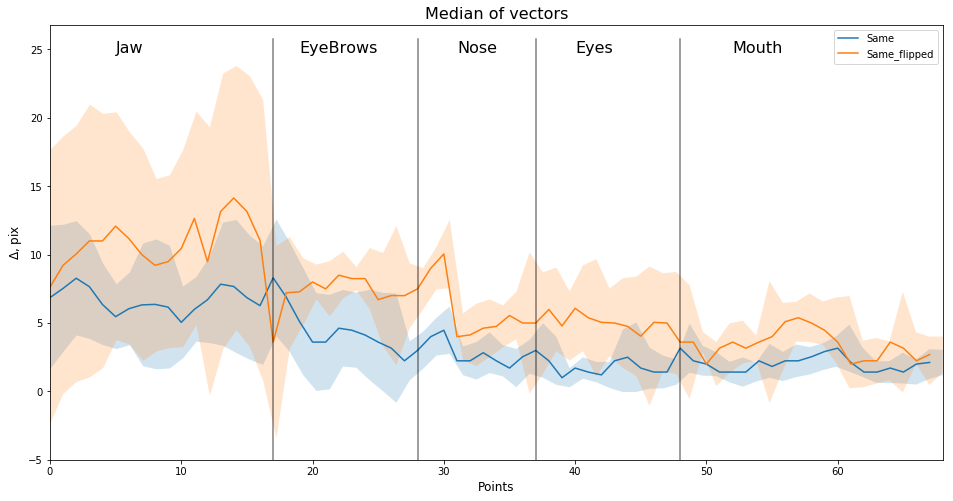

In [121]:
plot_vectors([vectors_same, vectors_same_flipped], ['Same', 'Same_flipped'])

Фотографии одно и того же человека и идентичных близнецов (identical)


In [106]:
vectors_same = get_features(identical, views, 25, same_preson=True, flipped=False)
vectors_identical = get_features(identical, views, 25, same_preson=False, flipped=False)

Detected: 25 N/Detected: 0
Detected: 25 N/Detected: 2


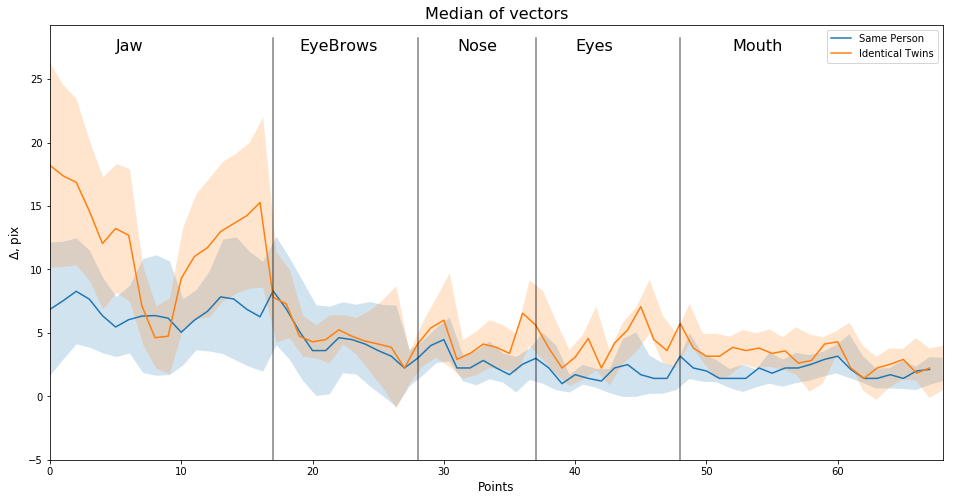

In [122]:
plot_vectors([vectors_same,vectors_identical], ['Same Person', 'Identical Twins'])

Глаза, нос и брови

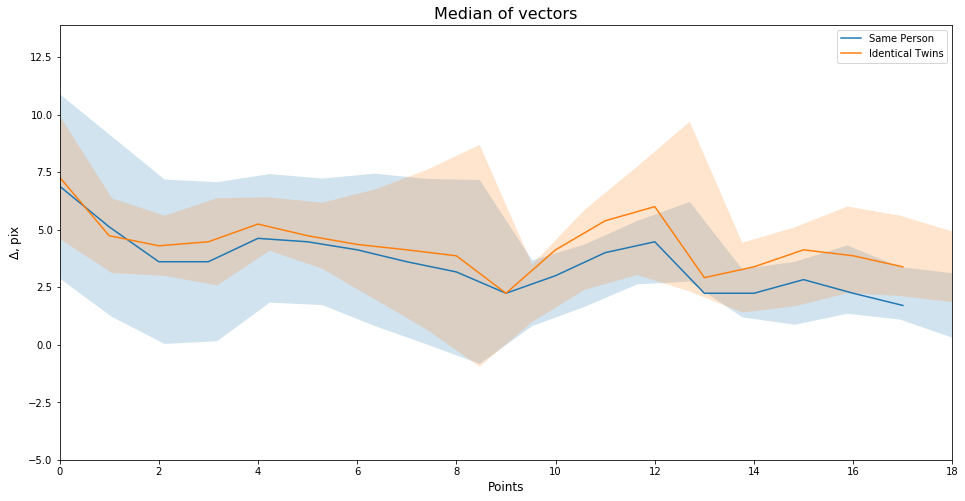

In [185]:
plot_vectors([cut_slice(vectors_same,[18,36]), cut_slice(vectors_identical,[18,36]), ], ['Same Person', 'Identical Twins',], print_areas=False)

Рот

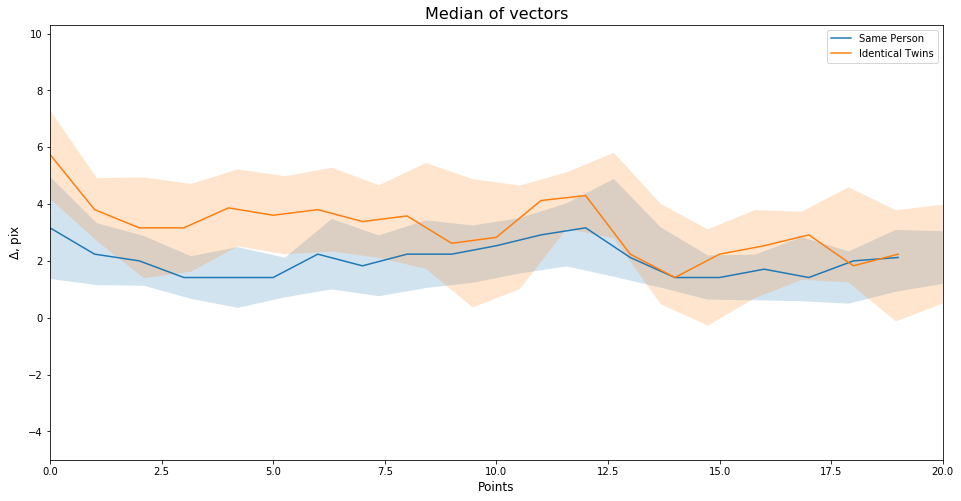

In [184]:
plot_vectors([cut_slice(vectors_same,'Mouth'), cut_slice(vectors_identical,'Mouth') ], ['Same Person', 'Identical Twins'], print_areas=False)

Same person Vs All others

In [194]:
vectors_same = get_features(different, views, 40, same_preson=True, flipped=False)
vectors_different = get_features(different, views, 40, same_preson=False, flipped=False)

Detected: 40 N/Detected: 0


TypeError: ignored

In [195]:
vectors_different = get_features(different, views, 40, same_preson=False, flipped=False)

Detected: 40 N/Detected: 2


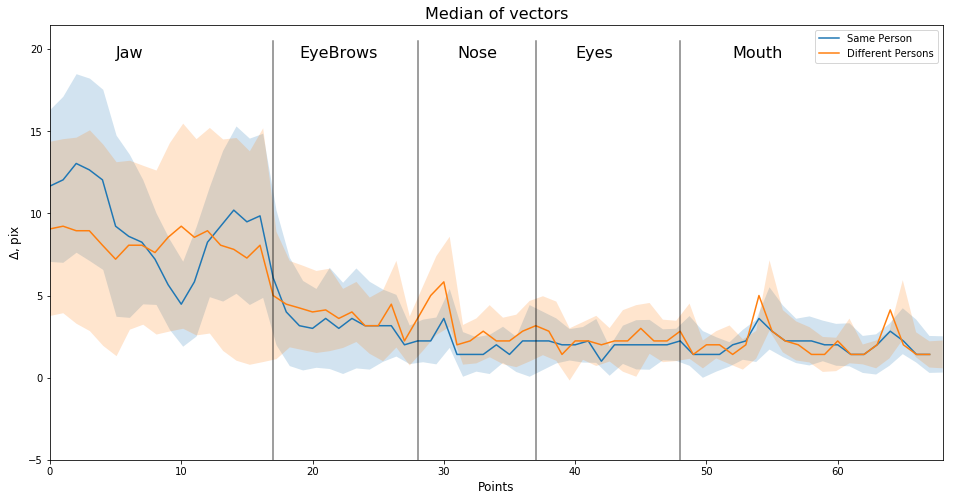

In [196]:
plot_vectors([vectors_same,vectors_different], ['Same Person', 'Different Persons'])

Mouth

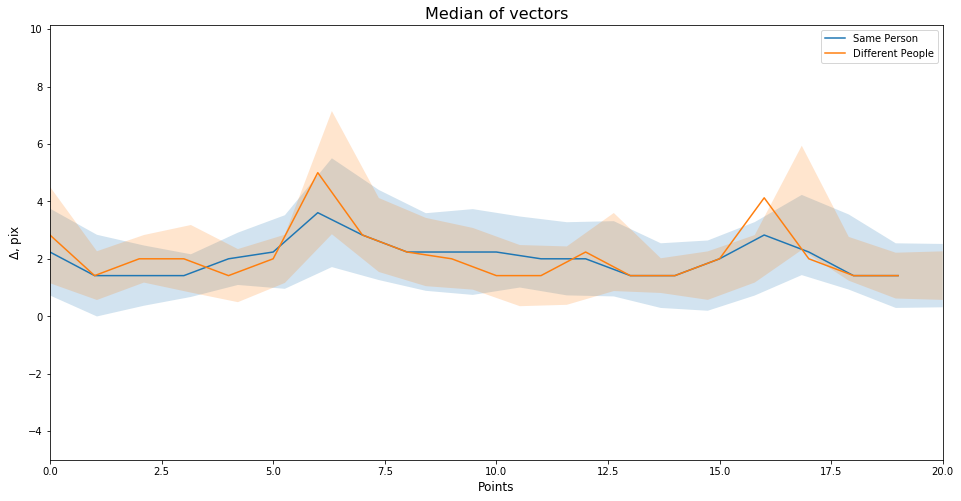

In [234]:
plot_vectors([cut_slice(vectors_same,'Mouth'), cut_slice(vectors_different,'Mouth') ], ['Same Person', 'Different People'], print_areas=False)

All other

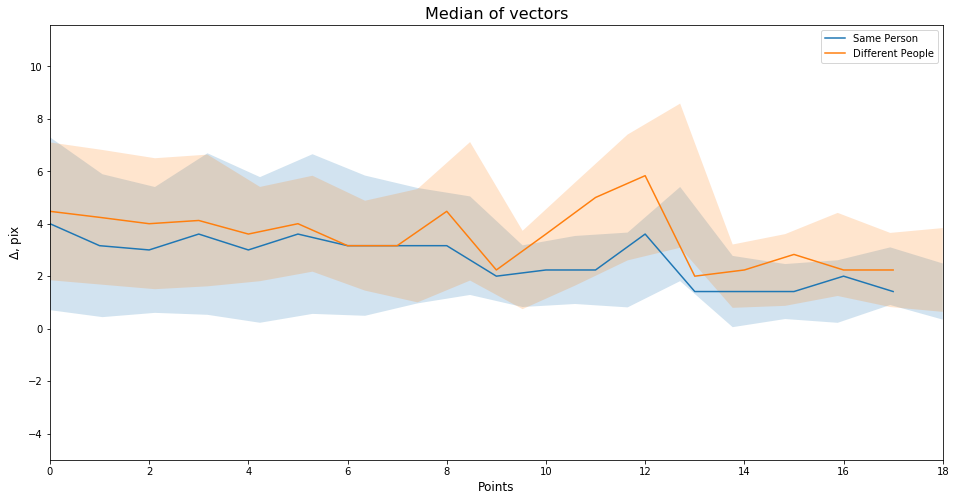

In [258]:
plot_vectors([innerface_same, innerface_different ], ['Same Person', 'Different People'], print_areas=False)

## Fit SVM Classifier

In [0]:
from sklearn.svm import SVC
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split

**Get only mouth features**

In [0]:
mouth_same, mouth_different = cut_slice(vectors_same,'Mouth'), cut_slice(vectors_different,'Mouth')
innerface_same, innerface_different = cut_slice(vectors_same,[18,36]), cut_slice(vectors_different,[18,36])

**Concat to X and y**

In [0]:
from sklearn.model_selection import cross_val_score

In [0]:
X = np.concatenate([mouth_same, mouth_different], axis = 0)
y = np.concatenate([np.ones(len(mouth_same)).astype(int), np.zeros(len(mouth_different)).astype(int)], axis =0)

In [0]:
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [0]:
svm = SVC(kernel='linear')

In [284]:
cross_val_score(svm, X, y, cv=5)

array([0.5   , 0.75  , 0.6875, 0.625 , 0.5   ])

In [273]:
svm.fit(X=X_train, y=y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [0]:
y_pred = svm.predict(X=X_test)

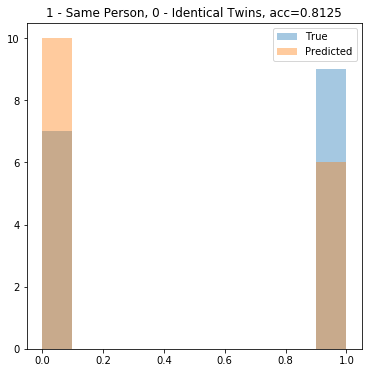

In [275]:
plt.figure(figsize=(6,6))
plt.hist(y_test, alpha=0.4, label='True')
plt.hist(y_pred, alpha=0.4, label='Predicted')
plt.title('1 - Same Person, 0 - Identical Twins, acc='+str(accuracy_score(y_test, y_pred).round(5)))
plt.legend()
plt.show()

**Test on fraternal class**

In [0]:
X_test = np.array(fraternal_lines)[:,48:]
y_test = np.ones(len(X_test)).astype(int)

In [0]:
fraternal_pred = svm.predict(X=X_test)

In [0]:
accuracy_score(y_test, fraternal_pred)

0.2357142857142857